## Parsing failures

We use a simple k-means algorithm group parsing failures.

### Run the recipe to find parse failures and download their Data Tables

Run [this recipe](https://public.moderne.io/recipes/org.openrewrite.FindParseFailures). \
Insert the downloaded data table (in XLSX) and your OpenAI token below. \

_Note: If you have opened this notebook from Moderne, the data table is already loaded locally as `./parse_failures.xlsx`._

In [17]:
data_table_file = "./parse-failures.xlsx"

In [ ]:
import piplite

await piplite.install('pandas')
await piplite.install('openpyxl')

In [4]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

In [ ]:
df = pd.read_excel(data_table_file,engine="openpyxl")

In [23]:
import openai

embedding_cache = {}

def get_embedding(st):
    if st not in embedding_cache:
        embedding_cache[st] = openai.Embedding.create(input=st, engine="text-embedding-ada-002")['data'][0]['embedding']
    return embedding_cache[st]

df["embedding"] = df["stackTrace"].map(get_embedding)
print(f"{len(embedding_cache)} unique stack traces")

81 unique stack traces


In [6]:
import numpy as np

matrix = np.vstack(df["embedding"].values)
matrix.shape

(180, 1536)

### Find the clusters using K-means

We show the simplest use of K-means. You can pick a different number of clusters if there is a sense that there is more parsing errors. scikit-learn must be at version 1.2.0. `pip install --upgrade scikit-learn` if necessary.

In [7]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.0.


In [19]:
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init='auto')
kmeans.fit(matrix)
labels = kmeans.labels_
df["cluster"] = labels

A good color selector by number of clusters is available at [ColorBrewer](https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=8).

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

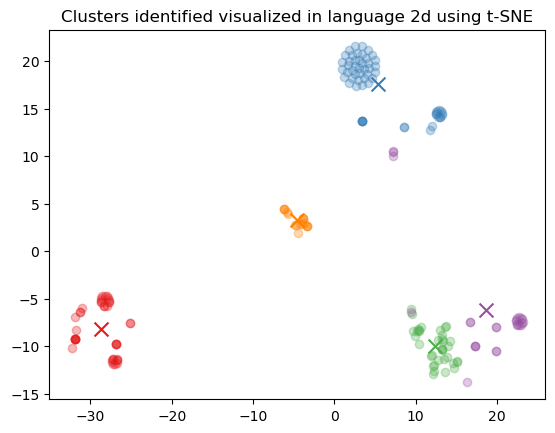

In [20]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection.

### Save the cluster data back to an XLSX file for later use.

In [24]:
df.to_excel(data_table_file.replace('.xlsx', '_clusters.xlsx'))

### Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use davinci-instruct-beta-v3 to name the clusters, based on a random sample of 6 failures from that cluster.

In [21]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 3

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    stackTraces = "\n".join(
        df[df.cluster == i]
        .stackTrace
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="davinci-instruct-beta-v3",
        prompt=f'What do the following errors have in common?\n\nError:\n"""\n{stackTraces}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.stackTrace.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme:  all of the errors are caused by a type mismatch between the expected type and the actual type.
java.lang.ClassCastException: groovy.transform.stc.FirstParam$FirstGen
java.lang.ClassCastException: groovy.transform.stc.FirstParam$FirstGen
java.lang.ClassCastException: groovy.transform.stc.FirstParam$FirstGen
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  all of these errors are caused by a problem with the javac compiler.
com.sun.tools.javac.util.Abort: null
  com.sun.tools.javac.comp.Check.
com.sun.tools.javac.util.Abort: null
  com.sun.tools.javac.comp.Check.
com.sun.tools.javac.util.Abort: null
  com.sun.tools.javac.comp.Check.
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  all of the errors are caused by a failure to parse the source code.
org.openrewrite.groovy.GroovyParsingException: Failed to parse genie-c
org.openrewrite

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.